# Analýza dat z futbalových zapasov z troch najvacších európskych lig

Tento notebook analyzuje data z fotbalových zápasů v anglické Premier League, nemeckej Budes Lige a talianskej Serii A. Cílem je zjistit, zda existuje korelace mezi počtem gólů v zápase a počtem fanoušků, kteří se na zápas zúčastnili, a také jak počet gólů ovlivňuje délku hry. S touto hypotézou se setkáváme v médiích a v diskusích o fotbale, ale zda je to pravda, se můžeme pokusit zjistit pomocí dat. Mne to osobne prišlo veľmi zaujímavé, preto som sa rozhodol túto hypotézu overiť. Keďže predtým ako by som sa na tieto data pozrel, povedal by som že čím je hra dlhšia tým viac gólov padne. No uvidíme či to tak naozaj je.

## 1. Načtení dat

In [50]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

# Načtení dat z CSV souboru ktore mame ulozene v adresari data. Ak by sme sme chceli viacej dat, je mozne pouzit API a stianut data z internetu aj inych lig.


print("Reading data bourmouth")
data_bournemouth = pd.read_csv("data/english_premier_league/afc_bournemouth.csv")

print("Reading data")
data = pd.DataFrame()

for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith(".csv"):
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            print(file)
            # Read the CSV and concatenate it to the data DataFrame
            data = pd.concat([data, pd.read_csv(file_path)], ignore_index=True)

data.to_csv('data.csv', index=False)

data.head()

Reading data bourmouth
Reading data
wolverhampton_wanderers.csv
burnley.csv
crystal_palace.csv
aston_villa.csv
brighton_&_hove_albion.csv
fulham.csv
liverpool.csv
newcastle_united.csv
luton_town.csv
chelsea.csv
brentford.csv
manchester_city.csv
west_ham_united.csv
tottenham_hotspur.csv
nottingham_forest.csv
afc_bournemouth.csv
sheffield_united.csv
arsenal.csv
manchester_united.csv
everton.csv
atalanta.csv
internazionale.csv
empoli.csv
hellas_verona.csv
bologna.csv
salernitana.csv
sassuolo.csv
lecce.csv
ac_milan.csv
torino.csv
udinese.csv
fiorentina.csv
cagliari.csv
genoa.csv
napoli.csv
monza.csv
lazio.csv
juventus.csv
as_roma.csv
frosinone.csv
fc_cologne.csv
bayer_leverkusen.csv
vfl_bochum.csv
rb_leipzig.csv
bayern_munich.csv
eintracht_frankfurt.csv
mainz.csv
borussia_dortmund.csv
1._fc_union_berlin.csv
borussia_monchengladbach.csv
1._fc_heidenheim_1846.csv
vfb_stuttgart.csv
werder_bremen.csv
vfl_wolfsburg.csv
fc_augsburg.csv
sc_freiburg.csv
sv_darmstadt_98.csv
tsg_hoffenheim.csv


,league,date,home_team,away_team,winner,home_team_goals,away_team_goals,score,venue,attendance,duration
0,English Premier League,2024-05-04T16:30Z,Manchester City,Wolverhampton Wanderers,Manchester City,5.0,1.0,5.0 - 1.0,Etihad Stadium,0,5400.0 + 300.0
1,English Premier League,2024-04-27T14:00Z,Wolverhampton Wanderers,Luton Town,Wolverhampton Wanderers,2.0,1.0,2.0 - 1.0,Molineux Stadium,31531,5400.0 + 420.0
2,English Premier League,2024-04-24T18:45Z,Wolverhampton Wanderers,AFC Bournemouth,AFC Bournemouth,0.0,1.0,0.0 - 1.0,Molineux Stadium,25541,5400.0 + 780.0
3,English Premier League,2024-04-20T18:30Z,Wolverhampton Wanderers,Arsenal,Arsenal,0.0,2.0,0.0 - 2.0,Molineux Stadium,31621,5400.0 + 420.0
4,English Premier League,2024-04-13T14:00Z,Nottingham Forest,Wolverhampton Wanderers,Draw,2.0,2.0,2.0 - 2.0,The City Ground,29604,5400.0 + 420.0


## 2. Předběžná analýza a čištění dat

In [43]:
# Informace o datech
data.info()

# Kontrola chybějících hodnot
data.isnull().sum()

# Zobrazení základních statistik
data.describe()

# Převedení sloupce 'date' na datetime formát
data['date'] = pd.to_datetime(data['date'])
data_bournemouth['date'] = pd.to_datetime(data_bournemouth['date'])

# Zpracování sloupce 'duration'
# Předpokládám, že formát je '5400.0 + 540.0', což může znamenat 5400 sekund + 540 sekund
# Nejprve rozdělíme tento sloupec a sečteme hodnoty
def parse_duration_simple(duration_str):
    try:
        parts = duration_str.split('+')
        return sum(float(part.strip()) for part in parts)
    except:
        return np.nan

data['duration_seconds'] = data['duration'].apply(parse_duration_simple)
data_bournemouth['duration_seconds'] = data_bournemouth['duration'].apply(parse_duration_simple)

# Převod sekund na minuty
data['duration_minutes'] = data['duration_seconds'] / 60
data_bournemouth['duration_minutes'] = data_bournemouth['duration_seconds'] / 60

# Zobrazení upravených dat
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   league           1988 non-null   object 
 1   date             1988 non-null   object 
 2   home_team        1988 non-null   object 
 3   away_team        1988 non-null   object 
 4   winner           1988 non-null   object 
 5   home_team_goals  1988 non-null   float64
 6   away_team_goals  1988 non-null   float64
 7   score            1988 non-null   object 
 8   venue            1988 non-null   object 
 9   attendance       1988 non-null   int64  
 10  duration         1988 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 171.0+ KB


,league,date,home_team,away_team,winner,home_team_goals,away_team_goals,score,venue,attendance,duration,duration_seconds,duration_minutes
0,English Premier League,2024-05-04 16:30:00+00:00,Manchester City,Wolverhampton Wanderers,Manchester City,5.0,1.0,5.0 - 1.0,Etihad Stadium,0,5400.0 + 300.0,5700.0,95.0
1,English Premier League,2024-04-27 14:00:00+00:00,Wolverhampton Wanderers,Luton Town,Wolverhampton Wanderers,2.0,1.0,2.0 - 1.0,Molineux Stadium,31531,5400.0 + 420.0,5820.0,97.0
2,English Premier League,2024-04-24 18:45:00+00:00,Wolverhampton Wanderers,AFC Bournemouth,AFC Bournemouth,0.0,1.0,0.0 - 1.0,Molineux Stadium,25541,5400.0 + 780.0,6180.0,103.0
3,English Premier League,2024-04-20 18:30:00+00:00,Wolverhampton Wanderers,Arsenal,Arsenal,0.0,2.0,0.0 - 2.0,Molineux Stadium,31621,5400.0 + 420.0,5820.0,97.0
4,English Premier League,2024-04-13 14:00:00+00:00,Nottingham Forest,Wolverhampton Wanderers,Draw,2.0,2.0,2.0 - 2.0,The City Ground,29604,5400.0 + 420.0,5820.0,97.0


## 3. Analýza korelace medzi počtem gólů a počtem fanoušků pre team Bournemouth

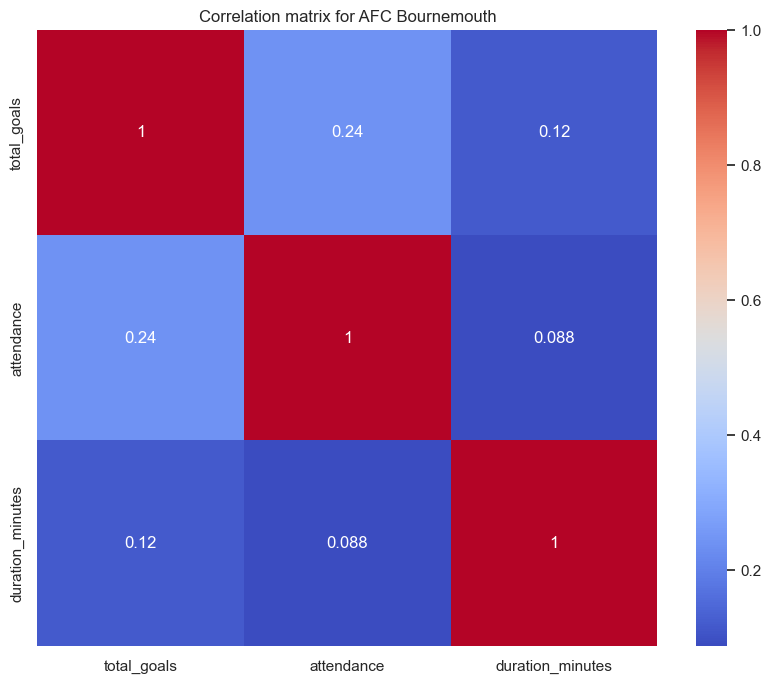

In [45]:
# Možeme si to zanalyzovať iba pre jeden team a to team AFC Bournemouth

data_bournemouth['total_goals'] = data_bournemouth['home_team_goals'] + data_bournemouth['away_team_goals']
analysis_data_bournemouth = data_bournemouth[['total_goals', 'attendance', 'duration_minutes']].dropna()

correlation_matrix_bournemouth = analysis_data_bournemouth.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_bournemouth, annot=True, cmap='coolwarm')
plt.title('Correlation matrix for AFC Bournemouth')
plt.show()

Z grafu je vidieť, že dĺžka hry nemá žiaden vlypv na počet gólov. Korelacia je 0.088 co je veľmi nízka hodnota. Čož ma celkom prekvapuje keďze som očakával že čím je hra dlhšia tým viac gólov padne. Aspoň by mi to tak prišlo logické. Uvidíme či to bude platiť aj pre ostatné tímy. Keď budeme mať výsledky pre všetky tímy, tak môžeme zistiť či je to len náhoda alebo to naozaj tak je.

Korelacia medzi počtom gólov a počtom fanúšikov je o niečo vyššia, ale stále je to pomerne malá hodnota.

## 4. Analýza korelace mezi počtem gólů a účastí fanoušků pre všetky tímy

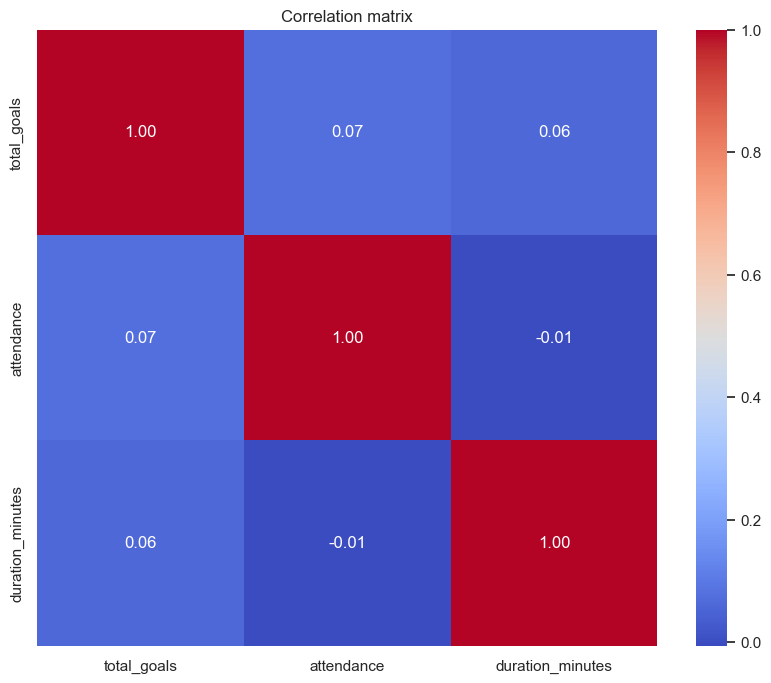

In [46]:
# Zaměříme se na domácí tým a počet gólů a attendance
# Podobně můžeme analyzovat i pro hostující tým

# Vytvoření nových sloupců pro celkový počet gólů
data['total_goals'] = data['home_team_goals'] + data['away_team_goals']

# Vybrání relevantních sloupců
analysis_data = data[['total_goals', 'attendance', 'duration_minutes']].dropna()

# Korelační matice
correlation_matrix = analysis_data.corr()

correlation_matrix

# Vizualizace korelační matice - using heatmap and seaborn

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

Ako môžeme vidieť z grafu, korelácia medzi počtom gólov a počtom fanúšikov je ešte menšia dokonca v nejakom pripade až minusová. Čiže na vačších datách sa nám táto hypotéza nepotvrdila. A je viditelnejsie že dĺžka hry nemá žiaden vplyv na počet gólov. Tak isto ako aj počet fanúšikov. Skusíme na to aplikovať este aj inu metódu a to je lineárna regresia.

### Pearsonův korelační koeficient

In [47]:
# Výpočet Pearsonova korelačního koeficientu mezi celkovým počtem gólů a attendance
corr_goals_attendance, p_value_goals_attendance = stats.pearsonr(analysis_data['total_goals'], analysis_data['attendance'])

print(f"Pearsonův korelační koeficient mezi celkovým počtem gólů a attendance: {corr_goals_attendance:.4f}")
print(f"p-hodnota: {p_value_goals_attendance:.4f}")

Pearsonův korelační koeficient mezi celkovým počtem gólů a attendance: 0.0740
p-hodnota: 0.0010


Ak pouzijeme obvyklej hladiny vyznamnosti α=0.05, mozeme potom porovnat s nasou P-hodnotou.

Kedze nasa P-hodnota je mensia ako hladina vynamnosti tak mozeme tuto nulovu hypotezu zamietnut.

## 5. Lineární regrese: Jak počet gólů ovlivňuje attendance a délku hry

Lineární regrese pro Attendance:
Koeficient: 737.4008
Intercept: 33107.2201


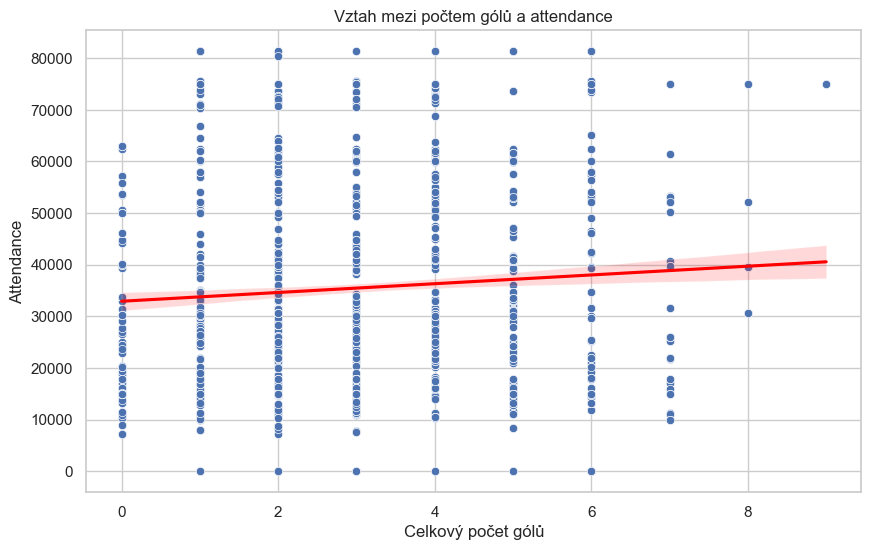

In [48]:
# Definování nezávislé proměnné (X) a závislých proměnných (y)
X = analysis_data[['total_goals']]

# Pro attendance
y_attendance = analysis_data['attendance']

# Rozdělení dat na tréninkovou a testovací sadu
X_train, X_test, y_train_attendance, y_test_attendance = train_test_split(X, y_attendance, test_size=0.2, random_state=42)

# Vytvoření modelu lineární regrese
model_attendance = LinearRegression()
model_attendance.fit(X_train, y_train_attendance)

# Predikce na testovací sadě
y_pred_attendance = model_attendance.predict(X_test)

# Výsledky modelu
print("Lineární regrese pro Attendance:")
print(f"Koeficient: {model_attendance.coef_[0]:.4f}")
print(f"Intercept: {model_attendance.intercept_:.4f}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='total_goals', y='attendance', data=analysis_data)
sns.regplot(x='total_goals', y='attendance', data=analysis_data, scatter=False, color='red')
plt.title('Vztah mezi počtem gólů a attendance')
plt.xlabel('Celkový počet gólů')
plt.ylabel('Attendance')
plt.show()


## 6. Analýza korelace a regrese mezi počtem gólů a délkou hry

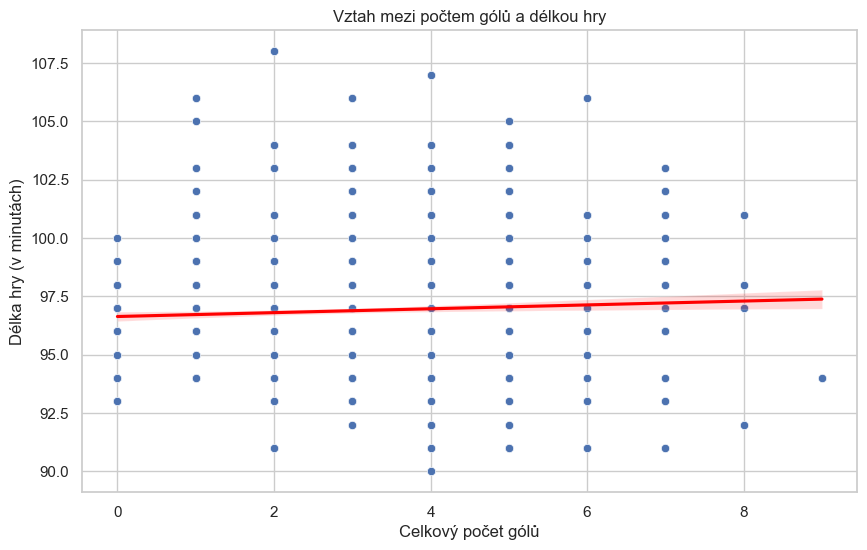

In [49]:
# Pro délku hry
y_duration = analysis_data['duration_minutes']

# Rozdělení dat na tréninkovou a testovací sadu
X_train, X_test, y_train_duration, y_test_duration = train_test_split(X, y_duration, test_size=0.2, random_state=42)

# Vytvoření modelu lineární regrese
model_duration = LinearRegression()
model_duration.fit(X_train, y_train_duration)

# Predikce na testovací sadě
y_pred_duration = model_duration.predict(X_test)
plt.figure(figsize=(10,6))
sns.scatterplot(x='total_goals', y='duration_minutes', data=analysis_data)
sns.regplot(x='total_goals', y='duration_minutes', data=analysis_data, scatter=False, color='red')
plt.title('Vztah mezi počtem gólů a délkou hry')
plt.xlabel('Celkový počet gólů')
plt.ylabel('Délka hry (v minutách)')
plt.show()

## 7. Závěry

Ako sme sa uz mohli presvedčiť z hore uvedených grafov. Môžeme usúdiď záver a byť si pomerne istý že nexistuje žiadna korelácia a preto naše hypotezý fungovať nebudu. Čož ma prekvapilo, keďže som do toho išiel stým že je dosť intuitívne že počet gólov v zápase sa bude zväčšovaním času taktiež zväčšovať. No data nám ukazali niečo iné.